# Signal Event Lab

Visualize final `SignalEvent` outputs from `signal_engine.py` without modifying `ema_lab`.

This chart overlays `Close`, `EMA_50`, `EMA_200`, and signal transition markers.


Indicator file: out/indicators/APO.csv
Signal file:    out/signals/engine/APO.csv
Rows: 782 | Window rows: 753 | Events in window: 3


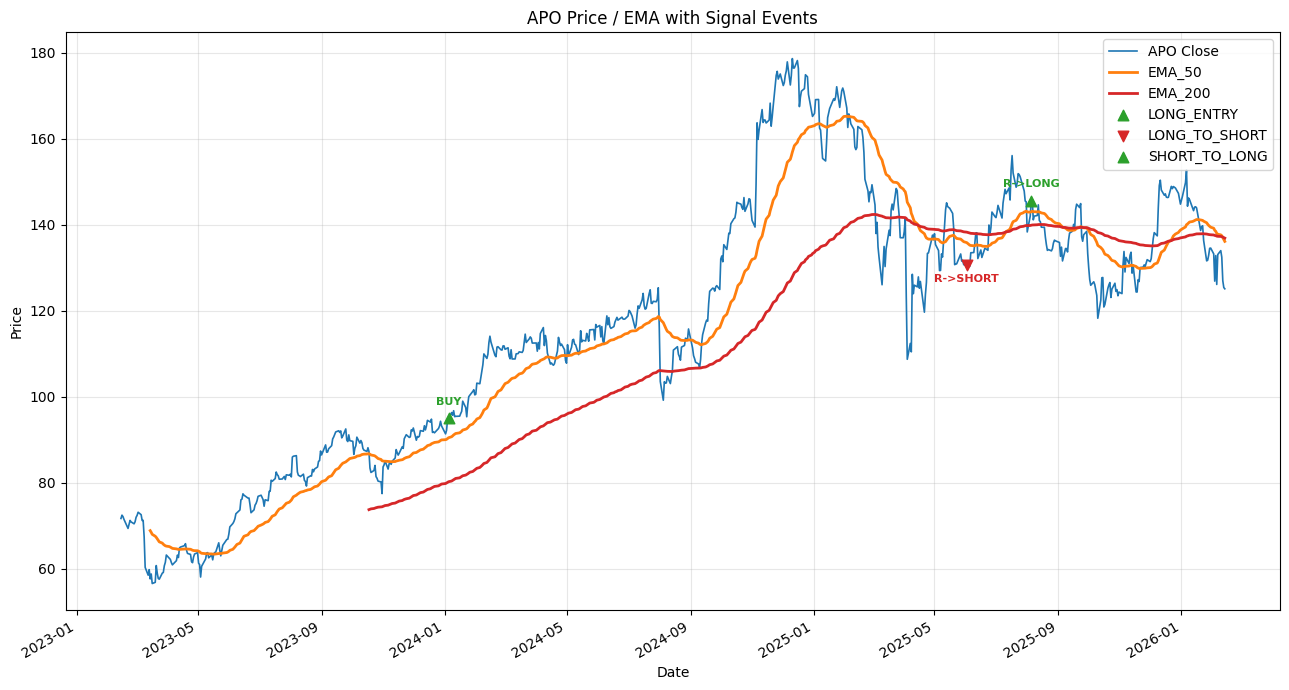


Latest 8 rows:
2026-02-04  Close=132.8000  EMA_50=138.4437  EMA_200=137.4362  SignalState=LONG  SignalEvent=
2026-02-05  Close=126.0800  EMA_50=137.9589  EMA_200=137.3232  SignalState=LONG  SignalEvent=
2026-02-06  Close=133.0300  EMA_50=137.7656  EMA_200=137.2805  SignalState=LONG  SignalEvent=
2026-02-09  Close=133.9500  EMA_50=137.6160  EMA_200=137.2473  SignalState=LONG  SignalEvent=
2026-02-10  Close=132.4300  EMA_50=137.4126  EMA_200=137.1994  SignalState=LONG  SignalEvent=
2026-02-11  Close=126.9500  EMA_50=137.0023  EMA_200=137.0974  SignalState=LONG  SignalEvent=
2026-02-12  Close=125.3700  EMA_50=136.5461  EMA_200=136.9807  SignalState=LONG  SignalEvent=
2026-02-13  Close=125.0700  EMA_50=136.0961  EMA_200=136.8622  SignalState=LONG  SignalEvent=


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "APO"
YEARS_TO_PLOT = 3

def resolve_data_dir(subdir: str) -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        target = candidate / "out" / subdir
        if target.exists():
            return target
    raise FileNotFoundError(
        f"Could not find out/{subdir}. Run Jupyter from repo root or notebooks/, and regenerate outputs first."
    )

def load_indicator_data(csv_path: Path) -> tuple[list[date], list[float], list[float | None], list[float | None]]:
    dates: list[date] = []
    closes: list[float] = []
    ema50: list[float | None] = []
    ema200: list[float | None] = []

    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            dates.append(date.fromisoformat(row["Date"]))
            closes.append(float(row["Close"]))
            raw_ema50 = (row.get("EMA_50") or "").strip()
            raw_ema200 = (row.get("EMA_200") or "").strip()
            ema50.append(float(raw_ema50) if raw_ema50 else None)
            ema200.append(float(raw_ema200) if raw_ema200 else None)

    return dates, closes, ema50, ema200

def load_signal_rows(csv_path: Path) -> dict[date, dict[str, str]]:
    by_date: dict[date, dict[str, str]] = {}
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        for row in reader:
            row_date = date.fromisoformat(row["Date"])
            by_date[row_date] = row
    return by_date

indicator_dir = resolve_data_dir("indicators")
signal_dir = resolve_data_dir("signals")

indicator_csv = indicator_dir / f"{SYMBOL}.csv"
signal_csv = signal_dir / f"{SYMBOL}.csv"

if not indicator_csv.exists():
    raise FileNotFoundError(
        f"Missing file: {indicator_csv}. Run: python3 -m scripts.indicators.compute_ema --periods 50,200"
    )
if not signal_csv.exists():
    raise FileNotFoundError(
        f"Missing file: {signal_csv}. Run: python3 -m scripts.signals.signal_engine --min-hold-bars 5"
    )

dates, closes, ema50, ema200 = load_indicator_data(indicator_csv)
signal_rows = load_signal_rows(signal_csv)

if not dates:
    raise ValueError(f"No rows found in {indicator_csv}")

signal_events = [((signal_rows.get(d) or {}).get("SignalEvent") or "").strip() for d in dates]
signal_states = [((signal_rows.get(d) or {}).get("SignalState") or "FLAT").strip() for d in dates]

event_points = [(i, e) for i, e in enumerate(signal_events) if e]
window_start = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
start_idx = next((i for i, d in enumerate(dates) if d >= window_start), 0)

plot_dates = dates[start_idx:]
plot_close = closes[start_idx:]
plot_ema50 = ema50[start_idx:]
plot_ema200 = ema200[start_idx:]
window_events = [(i, e) for i, e in event_points if i >= start_idx]

print(f"Indicator file: {Path("out") / "indicators" / f"{SYMBOL}.csv"}")
print(f"Signal file:    {Path("out") / "signals" / f"{SYMBOL}.csv"}")
print(f"Rows: {len(dates)} | Window rows: {len(plot_dates)} | Events in window: {len(window_events)}")

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(plot_dates, plot_close, label=f"{SYMBOL} Close", color="#1f77b4", linewidth=1.2)
ax.plot(plot_dates, plot_ema50, label="EMA_50", color="#ff7f0e", linewidth=2.0)
ax.plot(plot_dates, plot_ema200, label="EMA_200", color="#d62728", linewidth=2.0)

event_style = {
    "LONG_ENTRY": {"color": "#2ca02c", "marker": "^", "text": "BUY", "offset": 10},
    "SHORT_ENTRY": {"color": "#d62728", "marker": "v", "text": "SELL", "offset": -12},
    "SHORT_TO_LONG": {"color": "#2ca02c", "marker": "^", "text": "R->LONG", "offset": 10},
    "LONG_TO_SHORT": {"color": "#d62728", "marker": "v", "text": "R->SHORT", "offset": -12},
}
legend_seen: set[str] = set()

for idx, event in window_events:
    style = event_style.get(event)
    if style is None:
        continue

    event_date = dates[idx]
    event_price = closes[idx]
    legend_label = event if event not in legend_seen else "_nolegend_"
    legend_seen.add(event)

    ax.scatter([event_date], [event_price], s=58, marker=style["marker"], color=style["color"], label=legend_label, zorder=6)
    ax.annotate(style["text"], (event_date, event_price), textcoords="offset points", xytext=(0, style["offset"]), ha="center", fontsize=8, color=style["color"], fontweight="bold")

ax.set_title(f"{SYMBOL} Price / EMA with Signal Events")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(alpha=0.3)
ax.legend(loc="best")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("\nLatest 8 rows:")
for idx in range(max(0, len(dates) - 8), len(dates)):
    ema50_text = "" if ema50[idx] is None else f"{ema50[idx]:.4f}"
    ema200_text = "" if ema200[idx] is None else f"{ema200[idx]:.4f}"
    print(f"{dates[idx]}  Close={closes[idx]:.4f}  EMA_50={ema50_text}  EMA_200={ema200_text}  SignalState={signal_states[idx]}  SignalEvent={signal_events[idx]}")
